# Solution provided by Chair

In [3]:
### IMPORTS
# basic
import random
import string
import pandas as pd
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud
# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juliusdoebelt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/juliusdoebelt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/juliusdoebelt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/juliusdoebelt/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Task 1: Data Analysis

In [17]:
data = pd.read_csv('spam.csv', sep='~')
data.head()

label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

In [6]:
data.shape

(5572, 2)

In [7]:
data.describe()

label                    text
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

In [8]:
data.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

([<matplotlib.patches.Wedge at 0x7fb234446bc0>,
 [Text(-0.44971325876899215, -1.0038714981945516, 'ham'),
  Text(0.4701548196619535, 1.0495019988302243, 'spam')])

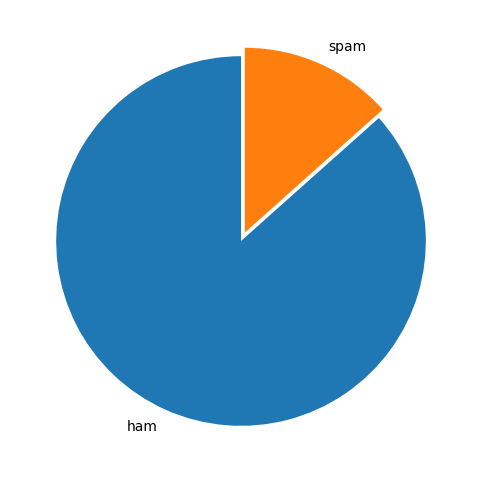

In [10]:
fig = plt.figure(figsize=(8,6))
plt.pie(data['label'].value_counts(), labels=['ham', 'spam'], startangle=90, explode=(0, 0.05))

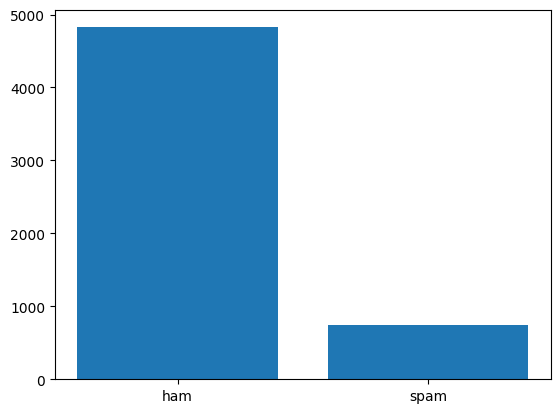

In [13]:
sub = data.groupby('label').count().reset_index()
plt.bar(sub['label'], sub['text'])
plt.show()

In [14]:
# check for duplicates
data.duplicated().sum() 

403

In [19]:
# drop duplicates
data.drop_duplicates(keep='first', inplace=True)
print(data.duplicated().sum())

0


Not exactly a classifier 

## Task 3: Feature Engineering

In [20]:
data['len'] = data['text'].apply(lambda x: len(x))
round(data['len'].describe(), 2)

count    5169.00
mean       79.53
std        58.47
min         2.00
25%        36.00
50%        61.00
75%       119.00
max       910.00
Name: len, dtype: float64

In [25]:
data.head()

label                                               text  len
0   ham  Go until jurong point, crazy.. Available only ...  111
1   ham                      Ok lar... Joking wif u oni...   29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...  155
3   ham  U dun say so early hor... U c already then say...   49
4   ham  Nah I don't think he goes to usf, he lives aro...   61

In [29]:
# inspecting the long message
print(data[data['len']==910]['text'].iloc[0])

For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..


Indeed, love starts with chicken curry 😋

In [32]:
px.histogram(data, 'len', nbins = 182, color = 'label')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'label=ham<br>len=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'ham',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'ham',
              'nbinsx': 182,
              'offsetgroup': 'ham',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([111,  29,  49, ...,  57, 125,  26]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'label=spam<br>len=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'spam',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': 'spam',
              'nbinsx': 182,
              'offsetgroup': 'spam',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([155, 148, 158, ..., 160, 147, 161]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'label'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'len'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'count'}}}
})

In [33]:
data['words'] = data['text'].apply(lambda x: len(x.split()))
round(data['words'].describe(), 2)

count    5169.00
mean       15.44
std        11.11
min         1.00
25%         7.00
50%        12.00
75%        22.00
max       171.00
Name: words, dtype: float64

In [35]:
data['words'].value_counts()

words
6      398
7      366
5      336
8      332
9      286
      ... 
77       1
72       1
69       1
68       1
162      1
Name: count, Length: 83, dtype: int64

In [36]:
px.histogram(data, 'words', nbins = 44, color = 'label')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'label=ham<br>words=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'ham',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'ham',
              'nbinsx': 44,
              'offsetgroup': 'ham',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([20,  6, 11, ..., 10, 26,  6]),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'label=spam<br>words=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'spam',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': 'spam',
              'nbinsx': 44,
              'offsetgroup': 'spam',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([28, 32, 26, ..., 28, 28, 30]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'label'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'words'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'count'}}}
})

## Task 4: Preprocessing of text

In [46]:
ex = 'I am a student of Business Informatics at the TU Dresden!!:) I would like to learn more about NLP'
punct = list(string.punctuation)
nop = [lett for lett in ex if not lett in punct]
clean = ''.join(nop)
clean

'I am a student of Business Informatics at the TU Dresden I would like to learn more about NLP'

In [47]:
print(f'random top words to get a feeling what kind of words are meant: {random.sample(stopwords.words("english"), 10)}')

random top words to get a feeling what kind of words are meant: ['too', 'where', 'off', 'have', "couldn't", 'as', 'doing', 'did', 'had', 'we']
['I', 'student', 'Business', 'Informatics', 'TU', 'Dresden', 'I', 'would', 'like', 'learn', 'NLP']


In [ ]:
clean = [word for word in clean.split(" ") if not word in stopwords.words('english')]
print(clean)

In [48]:
# to lower case
clean = [word.lower() for word in clean]
print(clean)

['i', 'student', 'business', 'informatics', 'tu', 'dresden', 'i', 'would', 'like', 'learn', 'nlp']


In [52]:
# stemming
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('went'))

went


In [54]:
# lemmatizsation
lemma = nltk.wordnet.WordNetLemmatizer()
print(lemma.lemmatize('went', nltk.corpus.wordnet.VERB))

go


Lemmatization also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English.

Stemming is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

Stemming is computationally much faster than Lemmatization, however performance and understanding is better for Lemmatization.

In [56]:
print([lemma.lemmatize(word, nltk.corpus.wordnet.VERB) for word in clean])
print('stemming')
print([stemmer.stem(word) for word in clean])

['i', 'student', 'business', 'informatics', 'tu', 'dresden', 'i', 'would', 'like', 'learn', 'nlp']
stemming
['i', 'student', 'busi', 'informat', 'tu', 'dresden', 'i', 'would', 'like', 'learn', 'nlp']


### Apply methods from above to our dataset

In [66]:
def preprocess(message):
    message = message.replace('å', '')
    nostop = ' '.join([word for word in message.split(' ') if not word in stopwords.words('english')])
    nopunct = ''.join([lett for lett in nostop if not lett in list(string.punctuation)])
    nocaps = [word.lower() for word in nopunct.split(' ')]
    norm = [stemmer.stem(word) for word in nocaps]
    return ' '.join(norm)

data['preprocessed'] = data['text'].apply(preprocess)

In [67]:
data.head()

label                                               text  len  words   
0   ham  Go until jurong point, crazy.. Available only ...  111     20  \
1   ham                      Ok lar... Joking wif u oni...   29      6   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...  155     28   
3   ham  U dun say so early hor... U c already then say...   49     11   
4   ham  Nah I don't think he goes to usf, he lives aro...   61     13   

                                        preprocessed  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4             nah i think goe usf live around though

## Task 5: Visualize most frequent words

In [68]:
ham_text = ' '.join(data[data['label']=='ham']['preprocessed'])
spam_text = ' '.join(data[data['label']=='spam']['preprocessed'])
# calc frequencies
ham_freq = nltk.FreqDist(nltk.word_tokenize(ham_text))
spam_freq = nltk.FreqDist(nltk.word_tokenize(spam_text))

In [69]:
ham_freq

FreqDist({'i': 1363, 'u': 891, 'im': 437, 'go': 404, 'you': 361, 'get': 352, 'it': 305, '2': 292, 'come': 275, 'ltgt': 254, ...})

<Axes: ylabel='count'>

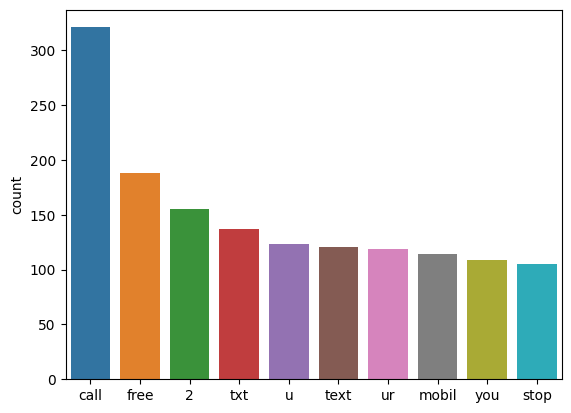

In [78]:
spam_freq_df = pd.DataFrame.from_dict(spam_freq, orient='index', columns=['count'])
sns.barplot(x=spam_freq_df.sort_values(by='count', ascending=False).head(10).index, y=spam_freq_df.sort_values(by='count', ascending=False).head(10)['count'])

<Axes: ylabel='count'>

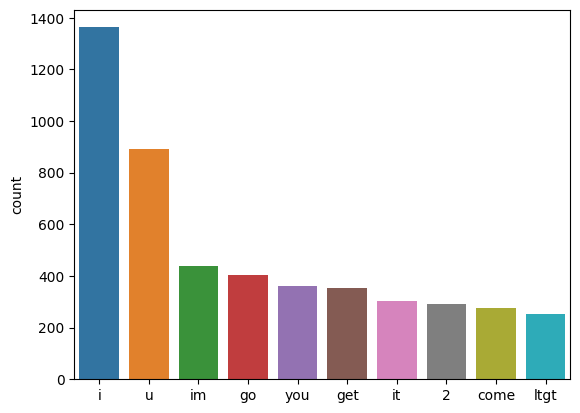

In [75]:
ham_freq_df = pd.DataFrame.from_dict(ham_freq, orient='index', columns=['count'])
sns.barplot(data=ham_freq_df.sort_values(by='count', ascending=False).head(10), x=ham_freq_df.sort_values(by='count', ascending=False).head(10).index, y='count')

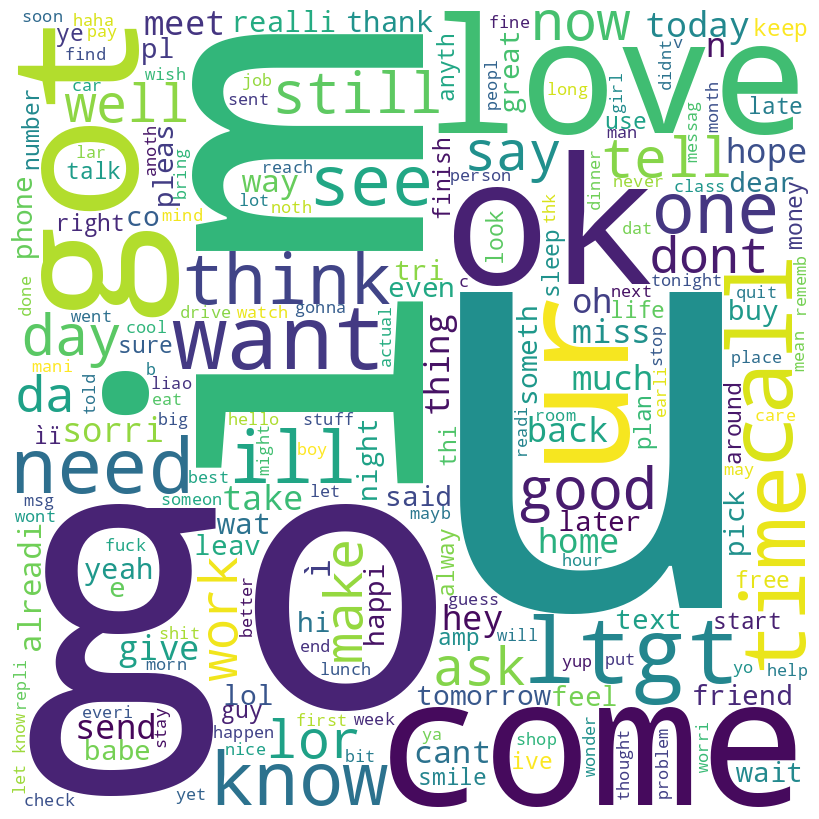

In [80]:
# wordcloud is coming for ham
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(ham_text)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

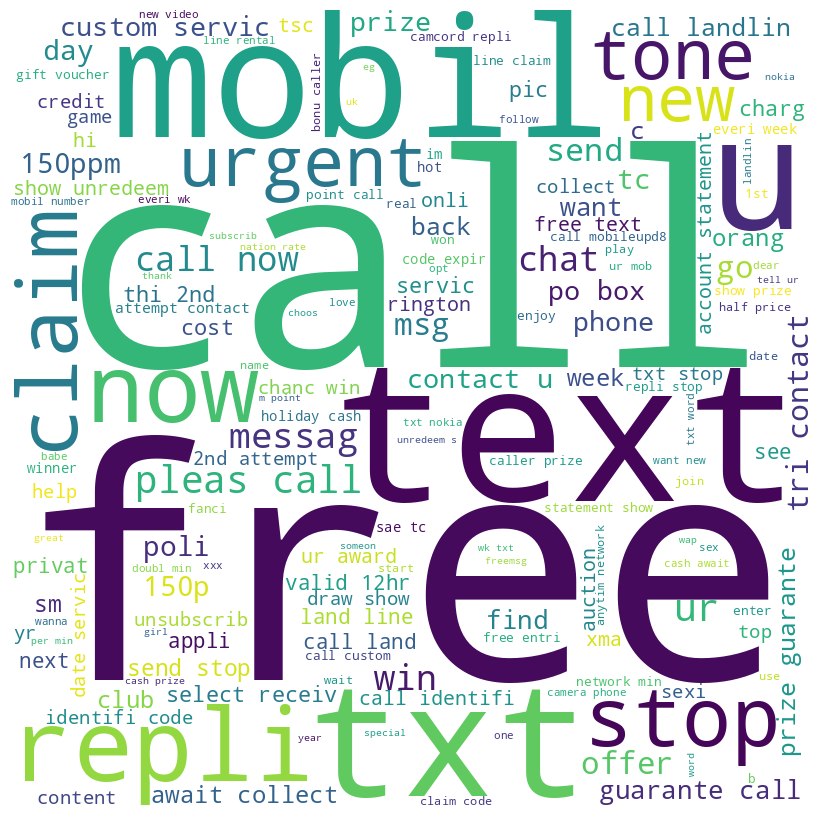

In [81]:
# wordcloud for spam
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(spam_text)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Task 6: Build Classifier 

In [87]:
low = data.text.str.lower()
# output is percentage of word in spam
print(f'£: {data[(low.str.contains("£"))]["label"].value_counts(normalize=True)[1]}')
print(f'free: {data[(low.str.contains("free"))]["label"].value_counts(normalize=True)[1]}')

£: 0.022935779816513763
free: 0.2683982683982684


In [86]:
data[(low.str.contains("£"))]['label'].value_counts(normalize=True)[1]

0.022935779816513763